# Setup

In [2]:
import numpy as np
from agents_clean import Agent
from model_clean import Model
from hybrid_networks_clean import rewire_network, randomize_network, create_hybrid_network, densify_network
from tqdm import tqdm
import networkx as nx
import pandas as pd
import random
from datetime import datetime
import itertools
from tqdm.contrib.itertools import product
import pickle
import numbers
#import opinionated
import matplotlib.pyplot as plt
#plt.style.use("opinionated_rc")
#import colormaps as cmaps  

# Load Networks

In [4]:
import dill

# Use dill to deserialize the graph from a file
with open('./getting_networks/perceptron_graph_pre_1979.pkl', 'rb') as f:
    G_perceptron = dill.load(f)

# Create a mapping from node names to indexes
mapping = {node: index for index, node in enumerate(G_perceptron.nodes())}

# Relabel the nodes in the graph
G_perceptron_indexed = nx.relabel_nodes(G_perceptron, mapping)
print('\n')
print(G_perceptron_indexed.nodes(data=True)[0])
print('\n')

# # Use dill to deserialize the graph from a file
with open('./getting_networks/peptic_ulcer_graph_pre_1978.pkl', 'rb') as f:
     G_pepticulcer = dill.load(f)

# # Create a mapping from node names to indexes
mapping = {node: index for index, node in enumerate(G_pepticulcer.nodes())}

# # Relabel the nodes in the graph
G_pepticulcer_indexed = nx.relabel_nodes(G_pepticulcer, mapping)
print('\n')
print(G_pepticulcer_indexed.nodes(data=True)[0])
print('\n')



{'authored_paper_count': 6, 'cited_count': 124, 'titles': ['The perceptron: A probabilistic model for information storage and organization in the brain.', 'PRINCIPLES OF NEURODYNAMICS. PERCEPTRONS AND THE THEORY OF BRAIN MECHANISMS', 'Analysis of a Four-Layer Series-Coupled Perceptron. II', 'The perceptron: A probabilistic model for information storage and organization in the brain.', 'Perceptron Simulation Experiments', 'PRINCIPLES OF NEURODYNAMICS. PERCEPTRONS AND THE THEORY OF BRAIN MECHANISMS', 'Perceptron Simulation Experiments', 'The perceptron: A probabilistic model for information storage and organization in the brain.', 'PRINCIPLES OF NEURODYNAMICS. PERCEPTRONS AND THE THEORY OF BRAIN MECHANISMS', 'PRINCIPLES OF NEURODYNAMICS. PERCEPTRONS AND THE THEORY OF BRAIN MECHANISMS', 'Analysis of a Four-Layer Series-Coupled Perceptron. II', 'PRINCIPLES OF NEURODYNAMICS. PERCEPTRONS AND THE THEORY OF BRAIN MECHANISMS', 'Analysis of a Four-Layer Series-Coupled Perceptron. II', 'Princip

# Setting Up the Functions

## Generate Parameters

In [7]:
def nth_moment(g,n):
    degree_np = np.array(list(dict(g.degree).values()))
    return (sum(degree_np**n)/len(g))

def generate_parameters_empir(n,G,rewiring_type='randomize'):
    params_list = []
    #print('Generating parameters...')
    for _ in tqdm(range(n),desc="Generating parameters"):
        #n_agents = random.randint(10, 500)
        n_agents = len(G.nodes())
        #ba_degree = random.randint(1, int(n_agents/10))
        #er_prob=random.uniform(0, 0.3)
        p_rewiring = random.uniform(0, 1)
        if rewiring_type=='hierarchical':
            #G_er = nx.gnp_random_graph(n_agents, er_prob, directed=True)
            network = rewire_network(G, p_rewiring=p_rewiring)
        if rewiring_type=='randomize':
            #G_ba = nx.barabasi_albert_graph(n_agents, ba_degree)
            network = randomize_network(G, p_rewiring=p_rewiring)
        # Calculate the mean degree of each node
        degrees = dict(network.degree())
        mean_degree = sum(degrees.values()) / len(degrees)
        uncertainty = random.uniform(0.001,0.025)
        n_experiments = random.randint(10, 10000)
        degree_variance = nth_moment(network,2)
        density = nx.density(network)
        avg_clustering = nx.average_clustering(network)
        try:
            avg_short_path_lenght = nx.average_shortest_path_length(network)
        except:
            avg_short_path_lenght = 0
        params = {
            "n_agents": n_agents,
            #"ba_degree": ba_degree,
            #"er_prob":er_prob,
            "p_rewiring": p_rewiring,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments,
            "rewiring_type":rewiring_type,
            'mean_degree':mean_degree,
            'avg_clustering': avg_clustering,
            'degree_variance': degree_variance,
            'density': density,
            'avg_short_path_lenght':avg_short_path_lenght,
        }
        params_list.append(params)
    return params_list

In [8]:
# Example usage
parameter_dictionaries = generate_parameters_empir(2,G_perceptron_indexed,
                                                   rewiring_type='randomize')  # Generate parameter dictionaries
parameter_dictionaries

Generating parameters: 100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


[{'n_agents': 3519,
  'p_rewiring': 0.8194495898493042,
  'network': <networkx.classes.digraph.DiGraph at 0x1506e2f90>,
  'uncertainty': 0.02461388966093998,
  'n_experiments': 5964,
  'rewiring_type': 'randomize',
  'mean_degree': 4.346689400397841,
  'avg_clustering': 0.0018473218752327097,
  'degree_variance': 30.924126172208013,
  'density': 0.0006177784821486414,
  'avg_short_path_lenght': 0},
 {'n_agents': 3519,
  'p_rewiring': 0.43102225843317954,
  'network': <networkx.classes.digraph.DiGraph at 0x1506df590>,
  'uncertainty': 0.020971090170954648,
  'n_experiments': 1782,
  'rewiring_type': 'randomize',
  'mean_degree': 4.346689400397841,
  'avg_clustering': 0.021005006992778293,
  'degree_variance': 88.09548167092925,
  'density': 0.0006177784821486414,
  'avg_short_path_lenght': 0}]

## Simulation Functions

In [9]:
def run_simulation_with_params(param_dict, number_of_steps=10000, 
                               agent_type="bayes",tolerance=1e-03):
    # Extract the network directly since it's already a NetworkX graph object
    my_network = param_dict['network']
    #agent_type = param_dict['agent_type']
    # Other parameters are directly extracted from the dictionary
    my_model = Model(my_network, n_experiments=param_dict['n_experiments'], uncertainty=param_dict['uncertainty']
                    , agent_type=agent_type,tolerance=tolerance)
    # Run the simulation with predefined steps and show_bar option
    
    my_model.run_simulation(number_of_steps=number_of_steps, show_bar=False)
  
    

    result_dict = {
        key: value 
        for key, value in param_dict.items() 
        if isinstance(value, (numbers.Number, str, tuple, list))}   
    result_dict['true_consensus'] = my_model.conclusion
    #result_dict['true_consensus_alternative_stop'] = my_model.conclusion_alternative_stop
    #df = pd.DataFrame(my_model.agents_choices) 
    #result_dict['choice_consensus'] = df.mean()[len(df.mean())-1]
    result_dict['convergence_step'] = my_model.n_steps # takes note of the last reported step
    result_dict['agent_type']=agent_type
    #result_dict['n_experiments']=param_dict['n_experiments']
    
    return result_dict


def run_simulations(param_list, number_of_steps=10000,agent_type="bayes",tolerance=1e-03):
    def run_simulation(param_dict,tolerance=tolerance):
        return run_simulation_with_params(param_dict, number_of_steps=number_of_steps, agent_type=agent_type)
    
    results = []
    # Iterate over each parameter dictionary in the list
    for params in tqdm(param_list, desc="Running simulations"):
        result = run_simulation(params)
        results.append(result)
    
    # Convert the list of results into a Pandas DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [10]:
# Test Simulation
parameter_dictionaries = generate_parameters_empir(1,G_perceptron_indexed,
                                                   rewiring_type='randomize')  # Generate parameter dictionaries
#print(parameter_dictionaries)
test_results_df = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                  agent_type="bayes",tolerance=1e-02)
test_results_df.to_csv('test_results_df.csv', index=False)
test_results_df.head()

Generating parameters:   0%|          | 0/1 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


,n_agents,p_rewiring,uncertainty,n_experiments,rewiring_type,mean_degree,avg_clustering,degree_variance,density,avg_short_path_lenght,true_consensus,convergence_step,agent_type
0,3519,0.474732,0.01634,9034,randomize,4.346689,0.019913,78.192668,0.000618,0,0.815857,5,bayes


## Plotting Functions

In [19]:
def plot_results(results_df=bayes_results_df, variable_of_interest='true_consensus', regressor='n_agents', agent_type='Bayes'):
    # Grouping the data by network type and regressor and calculating the mean for the variable of interest
    grouped = results_df.groupby(['rewiring_type', regressor])[variable_of_interest].mean().reset_index()

    # Preparing the figure
    plt.figure(figsize=(10, 8))

    # Looping over each network type and plotting the corresponding line
    for rewiring_type in results_df['rewiring_type'].unique():
        subset = grouped[grouped['rewiring_type'] == rewiring_type]
        plt.plot(subset[regressor], subset[variable_of_interest], marker='o', label=rewiring_type)

    # Setting the labels and title
    plt.xlabel(regressor)
    plt.ylabel('Share of ' + variable_of_interest)
    plt.title(agent_type+': '+ 'Share of ' + variable_of_interest + ' by ' + regressor)
    
    # Adding the legend for network types
    plt.legend(title='Network Type')

    # Enabling grid
    plt.grid(True)
    
    # Display the plot
    plt.show()

In [12]:
def plot_loglog(G,m=1):
    degree_freq = nx.degree_histogram(G)
    degrees = range(len(degree_freq))
    plt.figure(figsize=(12, 8))
    plt.loglog(degrees[m:], degree_freq[m:],'go-')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')

# Perceptron

Nodes in the network:
3519
Edges in the network:
7648


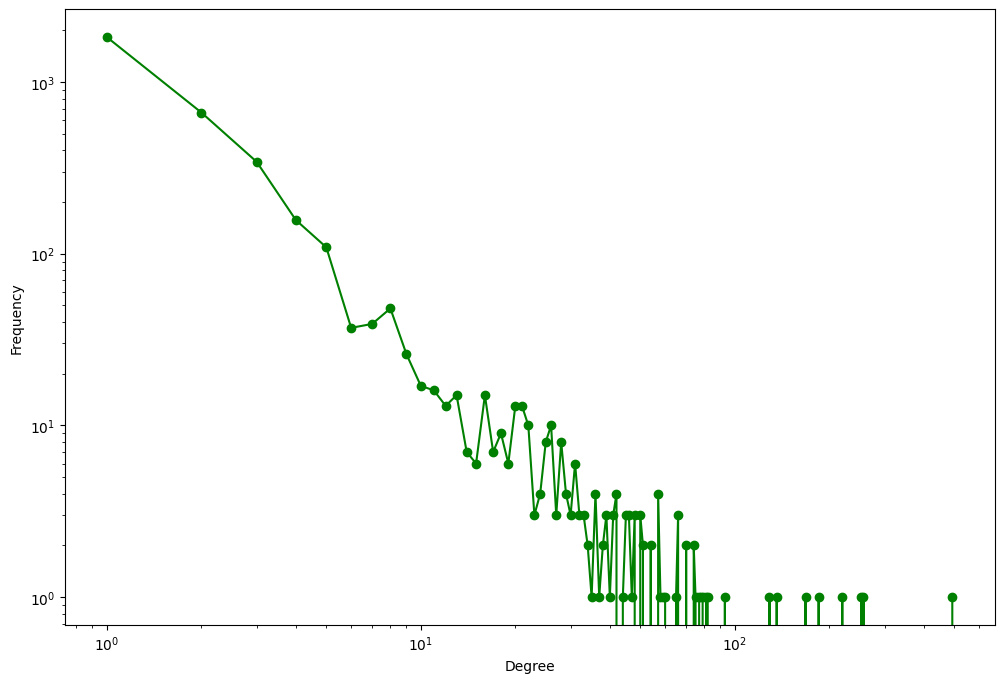

In [13]:
print("Nodes in the network:")
print(len(G_perceptron_indexed.nodes()))
# print("Edges in the network:")
# print(len(G.edges()))
#G_perceptron_indexed.nodes(data=True)
print("Edges in the network:")
print(len(G_perceptron_indexed.edges()))

plot_loglog(G_perceptron_indexed, m=1)

## Run Perceptron Simulations

In [14]:
# Bayes Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 10 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['randomize']:
        parameter_dictionaries = generate_parameters_empir(n_sims,G_perceptron_indexed,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                  agent_type="bayes",tolerance=1e-03)
        bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
        
    bayes_results_df.to_csv('./results_data/bayesagent_perceptron_results_df.csv', index=False)

saved_bayes_results_df = pd.read_csv('./results_data/bayesagent_perceptron_results_df.csv')

add_simulations = True
if add_simulations:
    n_sims = 490 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['randomize']:
        parameter_dictionaries = generate_parameters_empir(n_sims,G_perceptron_indexed,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                  agent_type="bayes",tolerance=1e-03)
        bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
    bayes_results_df = pd.concat([saved_bayes_results_df, bayes_results_df], ignore_index=True)
    bayes_results_df.to_csv('./results_data/bayesagent_perceptron_results_df.csv', index=False)
else: 
    bayes_results_df=saved_bayes_results_df

print(datetime.now())
    
bayes_results_df.info()

Generating parameters:   0%|          | 0/10 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]

2024-10-12 14:39:59.404201
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   n_agents               10 non-null     int64  
 1   p_rewiring             10 non-null     float64
 2   uncertainty            10 non-null     float64
 3   n_experiments          10 non-null     int64  
 4   rewiring_type          10 non-null     object 
 5   mean_degree            10 non-null     float64
 6   avg_clustering         10 non-null     float64
 7   degree_variance        10 non-null     float64
 8   density                10 non-null     float64
 9   avg_short_path_lenght  10 non-null     int64  
 10  true_consensus         10 non-null     float64
 11  convergence_step       10 non-null     int64  
 12  agent_type             10 non-null     object 
dtypes: float64(7), int64(4), object(2)
memory usage: 1.1+ KB



/var/folders/f5/dc26gyt54fs5nkjnk09tb5rw0000gp/T/ipykernel_5323/504729962.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)


In [15]:
# Beta Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 1
    beta_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['randomize']:
        parameter_dictionaries = generate_parameters_empir(n_sims,G_perceptron_indexed,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                  agent_type="beta",tolerance=1e-02)
        beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
        
    beta_results_df.to_csv('./results_data/betaagent_perceptron_results_df.csv', index=False)

saved_beta_results_df = pd.read_csv('./results_data/betaagent_perceptron_results_df.csv')

add_simulations = True
total_beta_results_df = pd.DataFrame(columns=saved_beta_results_df.columns)
if add_simulations:
    beta_results_df = pd.DataFrame(columns=saved_beta_results_df.columns)
    for l in [100,100,100,100]:
        n_sims = l# this is for each type of rewiring
        parameter_dictionaries = generate_parameters_empir(n_sims,G_perceptron_indexed,
                                                           rewiring_type='randomize')  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="beta",tolerance=1e-02)
        beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
            
        total_beta_results_df = pd.concat([saved_beta_results_df, beta_results_df], ignore_index=True)
        total_beta_results_df.to_csv('./results_data/betaagent_perceptron_results_df.csv', index=False)
else:
    beta_results_df = saved_beta_results_df
    
print(datetime.now())

beta_results_df.info()

Generating parameters:   0%|          | 0/1 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 1/1 [00:14<00:00, 14.18s/it]

2024-10-12 14:40:55.753450
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   n_agents               1 non-null      int64  
 1   p_rewiring             1 non-null      float64
 2   uncertainty            1 non-null      float64
 3   n_experiments          1 non-null      int64  
 4   rewiring_type          1 non-null      object 
 5   mean_degree            1 non-null      float64
 6   avg_clustering         1 non-null      float64
 7   degree_variance        1 non-null      float64
 8   density                1 non-null      float64
 9   avg_short_path_lenght  1 non-null      int64  
 10  true_consensus         1 non-null      float64
 11  convergence_step       1 non-null      int64  
 12  agent_type             1 non-null      object 
dtypes: float64(7), int64(4), object(2)
memory usage: 236.0+ bytes



/var/folders/f5/dc26gyt54fs5nkjnk09tb5rw0000gp/T/ipykernel_5323/2945501824.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)


## Now Some Plotting

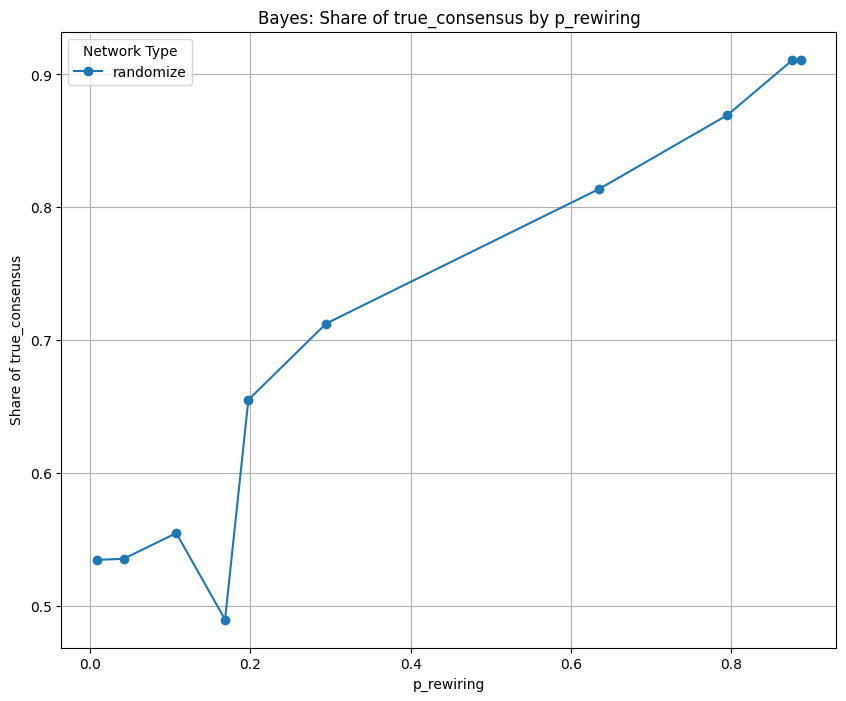

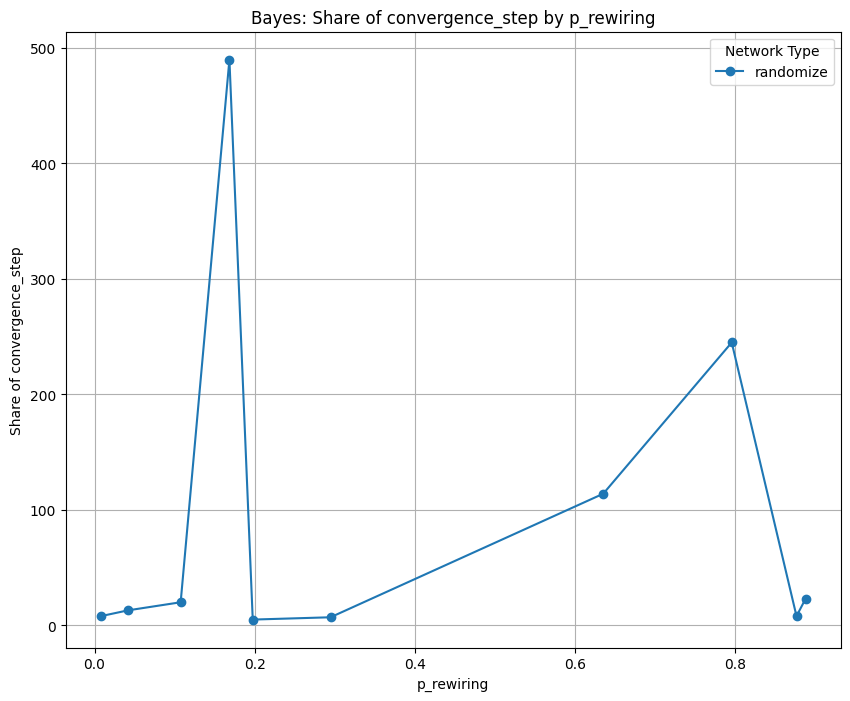

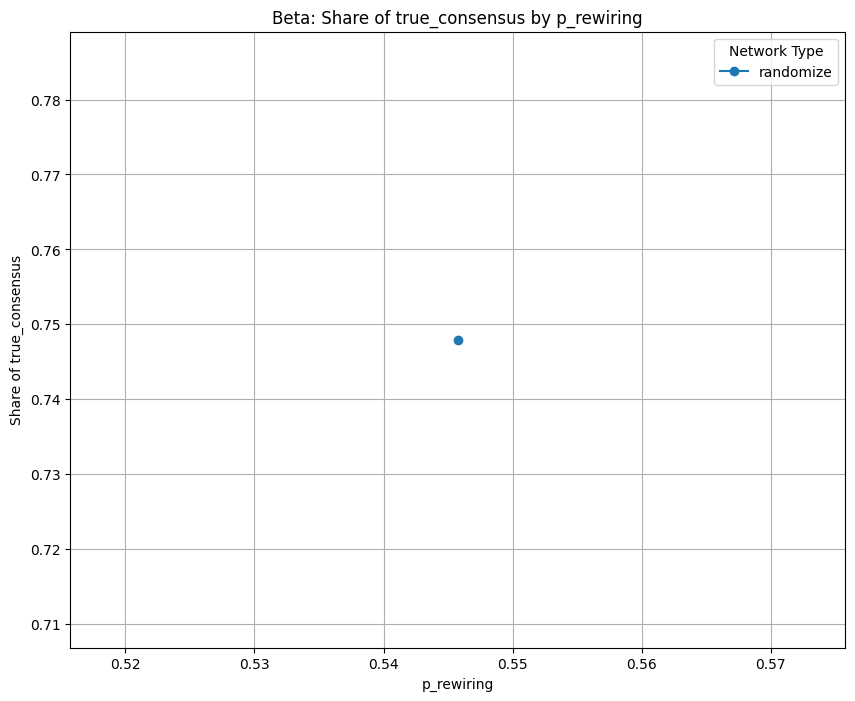

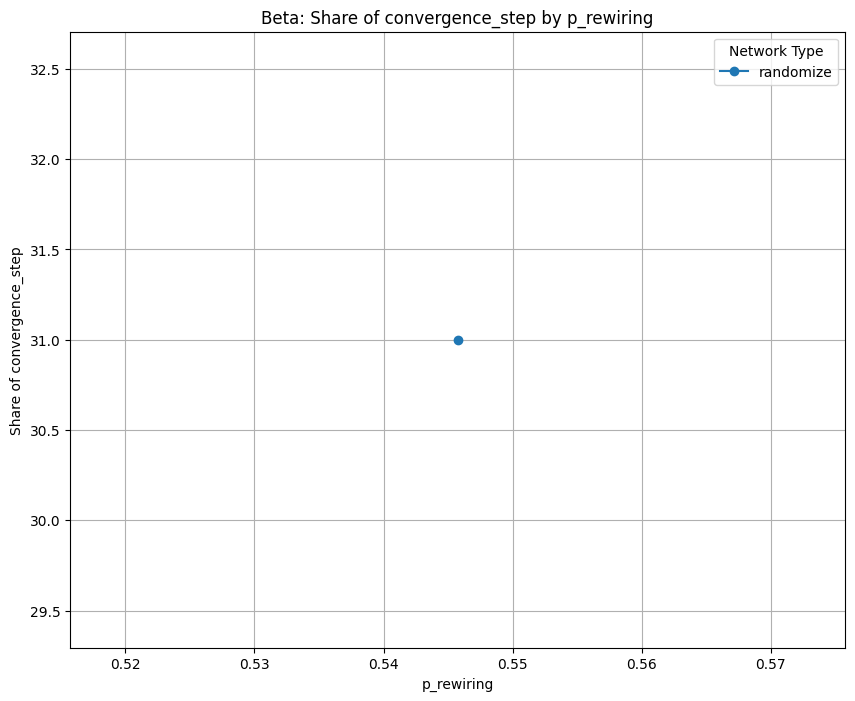

In [21]:
plot_results(bayes_results_df,variable_of_interest = 'true_consensus',regressor = 'p_rewiring',agent_type='Bayes')
plot_results(bayes_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring',agent_type='Bayes')
plot_results(beta_results_df,variable_of_interest = 'true_consensus',regressor = 'p_rewiring',agent_type='Beta')
plot_results(beta_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring',agent_type='Beta')

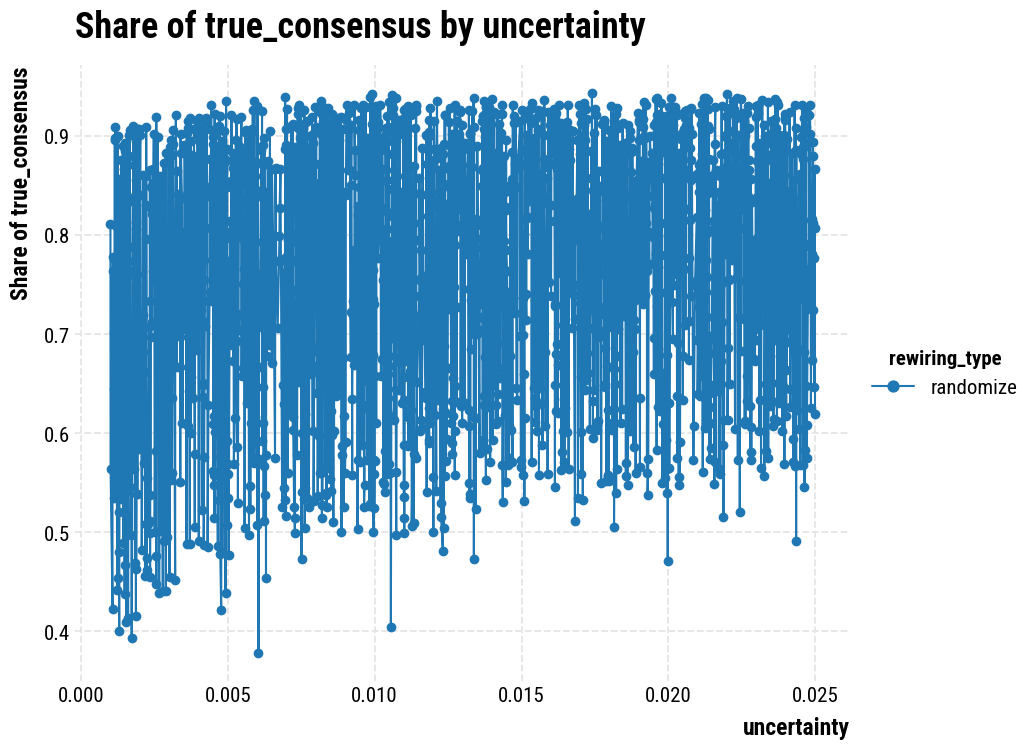

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


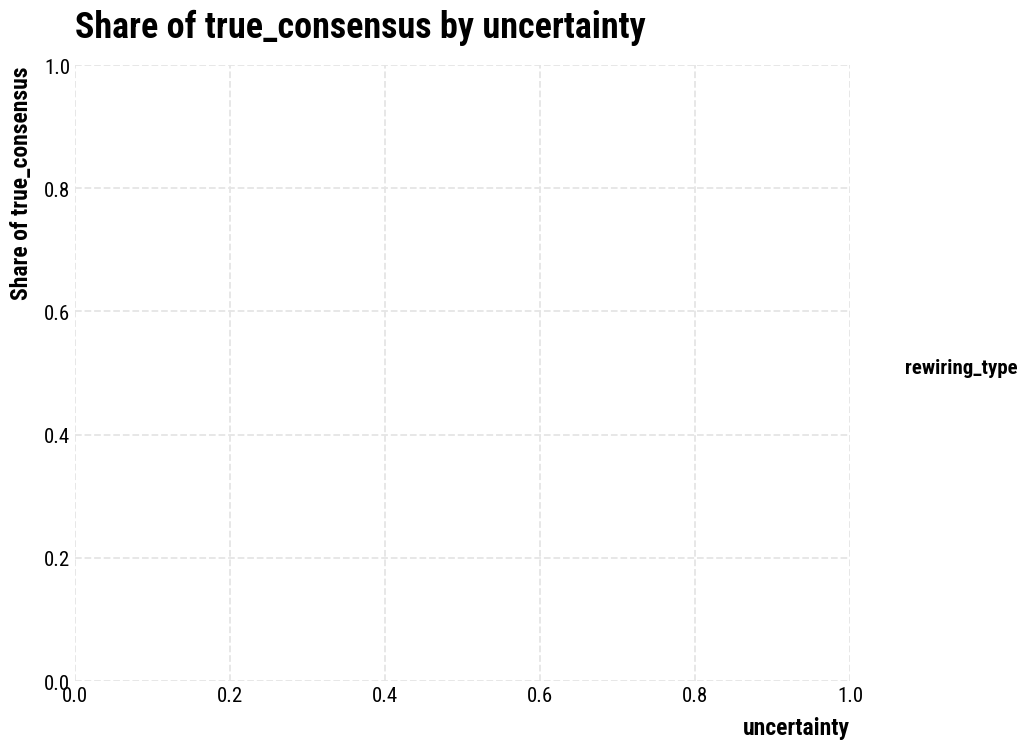

In [62]:
plot_results(bayes_results_df,variable_of_interest = 'true_consensus',regressor = 'uncertainty')
#plot_results(bayes_results_df,variable_of_interest = 'convergence_step',regressor = 'convergence_step')
plot_results(beta_results_df,variable_of_interest = 'true_consensus',regressor = 'uncertainty')
#plot_results(beta_results_df,variable_of_interest = 'convergence_step',regressor = 'convergence_step')

# Peptic Ulcer

Nodes in the network:
133403
Edges in the network:
785053


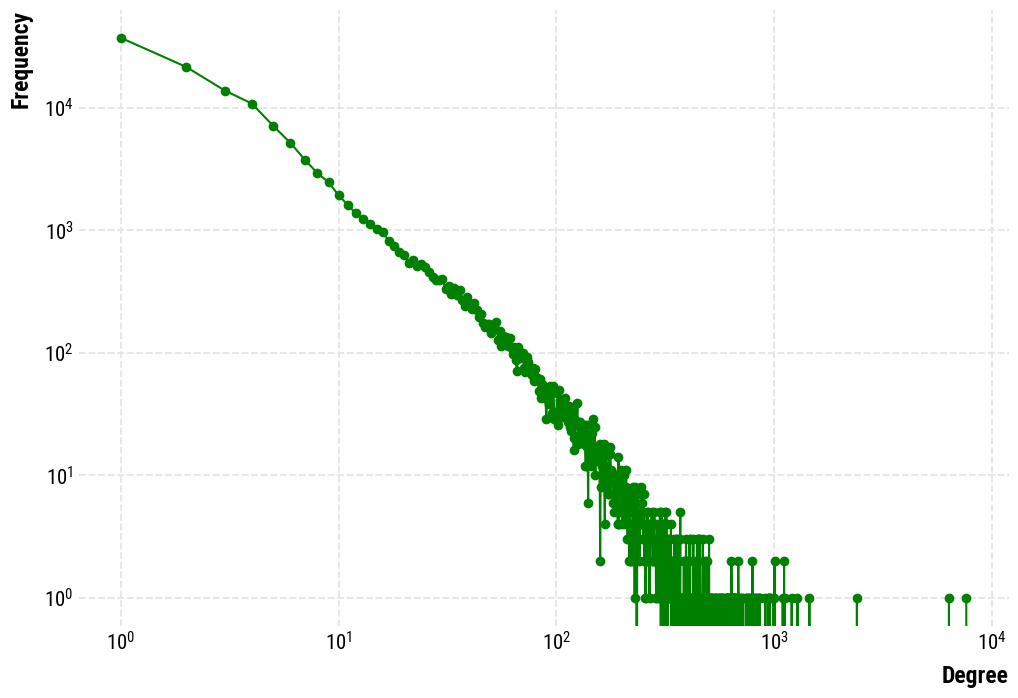

In [10]:
# # Use dill to deserialize the graph from a file
with open('data_proc/peptic_ulcer_graph_pre_1978.pkl', 'rb') as f:
     G_pepticulcer = dill.load(f)

# # Create a mapping from node names to indexes
mapping = {node: index for index, node in enumerate(G_pepticulcer.nodes())}

# # Relabel the nodes in the graph
G_pepticulcer_indexed = nx.relabel_nodes(G_pepticulcer, mapping)

print("Nodes in the network:")
print(len(G_pepticulcer_indexed.nodes()))
# print("Edges in the network:")
# print(len(G.edges()))
#G_pepticulcer_indexed.nodes(data=True)
print("Edges in the network:")
print(len(G_pepticulcer_indexed.edges()))

plot_loglog(G_pepticulcer_indexed,m=1)

In [12]:
# Test Simulation
parameter_dictionaries = generate_parameters_empir(1,G_pepticulcer_indexed,rewiring_type='randomize')  # Generate parameter dictionaries
#print(parameter_dictionaries)
test_results_df = run_simulations(parameter_dictionaries, number_of_steps=10000, agent_type="bayes")
test_results_df.to_csv('test_results_df.csv', index=False)
test_results_df.head()

Generating parameters:   0%|          | 0/1 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 1/1 [00:17<00:00, 17.82s/it]


,n_agents,p_rewiring,uncertainty,n_experiments,rewiring_type,mean_degree,true_consensus,convergence_step,agent_type
0,133403,0.682294,0.009325,7738,randomize,11.7696,0.991799,9,bayes


## Run Peptic Ulcer Simulations (only randomization, only bayes, but full network)

In [29]:
# Bayes Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 1 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['randomize']:
        parameter_dictionaries = generate_parameters_empir(n_sims,G_pepticulcer_indexed,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                  agent_type="bayes",tolerance=1e-02)
        bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
        
    bayes_results_df.to_csv('bayesagent_pepticulcer_results_df.csv', index=False)

saved_bayes_results_df = pd.read_csv('bayesagent_pepticulcer_results_df.csv')

add_simulations = False
if add_simulations:
    n_sims = 100 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['randomize']:
        parameter_dictionaries = generate_parameters_empir(n_sims,G_pepticulcer_indexed,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                  agent_type="bayes",tolerance=1e-02)
        bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
    bayes_results_df = pd.concat([saved_bayes_results_df, bayes_results_df], ignore_index=True)
    bayes_results_df.to_csv('bayesagent_pepticulcer_results_df.csv', index=False)
else: 
    bayes_results_df=saved_bayes_results_df
  
bayes_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   n_agents          500 non-null    int64  
 1   p_rewiring        500 non-null    float64
 2   uncertainty       500 non-null    float64
 3   n_experiments     500 non-null    int64  
 4   rewiring_type     500 non-null    object 
 5   mean_degree       500 non-null    float64
 6   true_consensus    500 non-null    float64
 7   convergence_step  500 non-null    int64  
 8   agent_type        500 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 35.3+ KB


In [73]:
# Beta Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 1
    beta_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['randomize']:
        parameter_dictionaries = generate_parameters_empir(n_sims,G_pepticulcer_indexed,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=5000, 
                                  agent_type="beta",tolerance=1e-02)
        beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
        
    beta_results_df.to_csv('betaagent_pepticulcer_results_df.csv', index=False)

saved_beta_results_df = pd.read_csv('betaagent_pepticulcer_results_df.csv')

add_simulations = False
total_beta_results_df = pd.DataFrame(columns=saved_beta_results_df.columns)
if add_simulations:
    beta_results_df = pd.DataFrame(columns=saved_beta_results_df.columns)
    for l in [50,50,50,50]:
        n_sims = l# this is for each type of rewiring
        parameter_dictionaries = generate_parameters_empir(n_sims,G_pepticulcer_indexed,
                                                           rewiring_type='randomize')  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=5000, 
                                agent_type="beta",tolerance=1e-02)
        beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
            
        total_beta_results_df = pd.concat([saved_beta_results_df, beta_results_df], ignore_index=True)
        total_beta_results_df.to_csv('betaagent_pepticulcer_results_df.csv', index=False)
else:
    beta_results_df = saved_beta_results_df
    
print(datetime.now())

beta_results_df.info()

2024-06-23 12:36:15.984540
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   n_agents          500 non-null    int64  
 1   p_rewiring        500 non-null    float64
 2   uncertainty       500 non-null    float64
 3   n_experiments     500 non-null    int64  
 4   rewiring_type     500 non-null    object 
 5   mean_degree       500 non-null    float64
 6   true_consensus    500 non-null    float64
 7   convergence_step  500 non-null    int64  
 8   agent_type        500 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 35.3+ KB


## Now Some Plotting

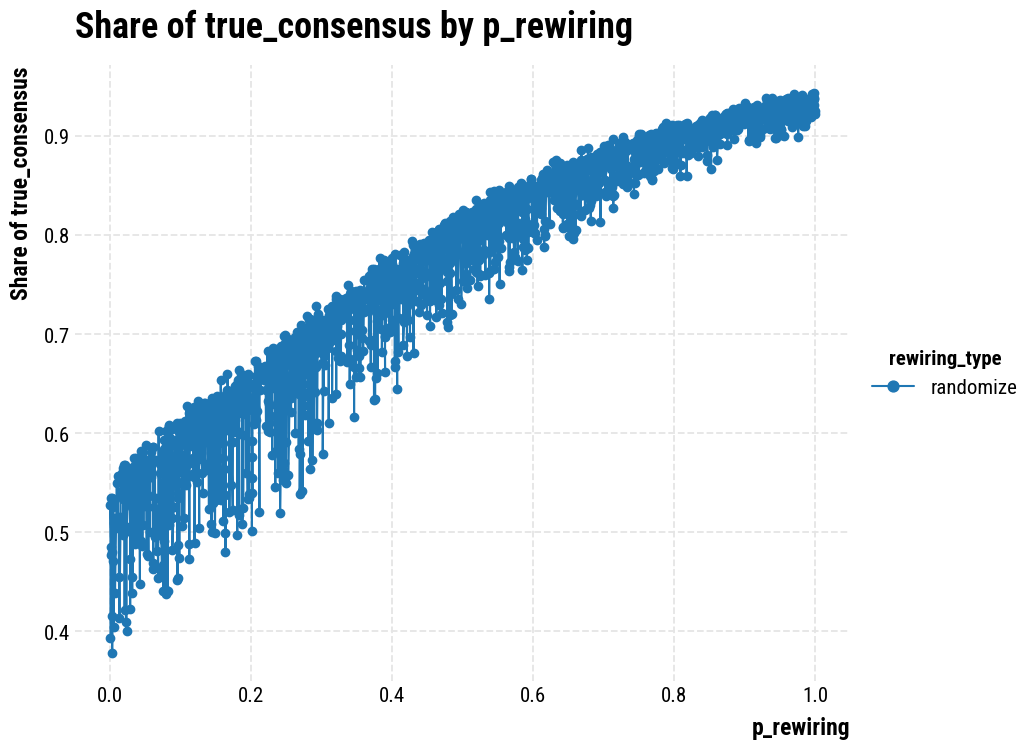

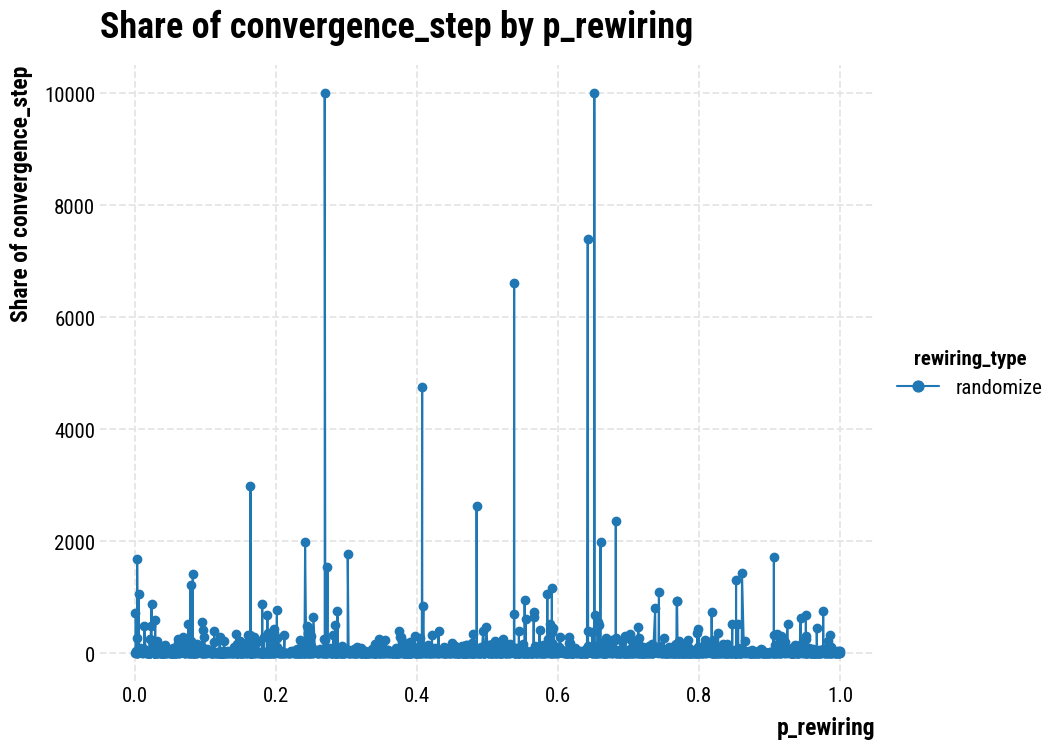

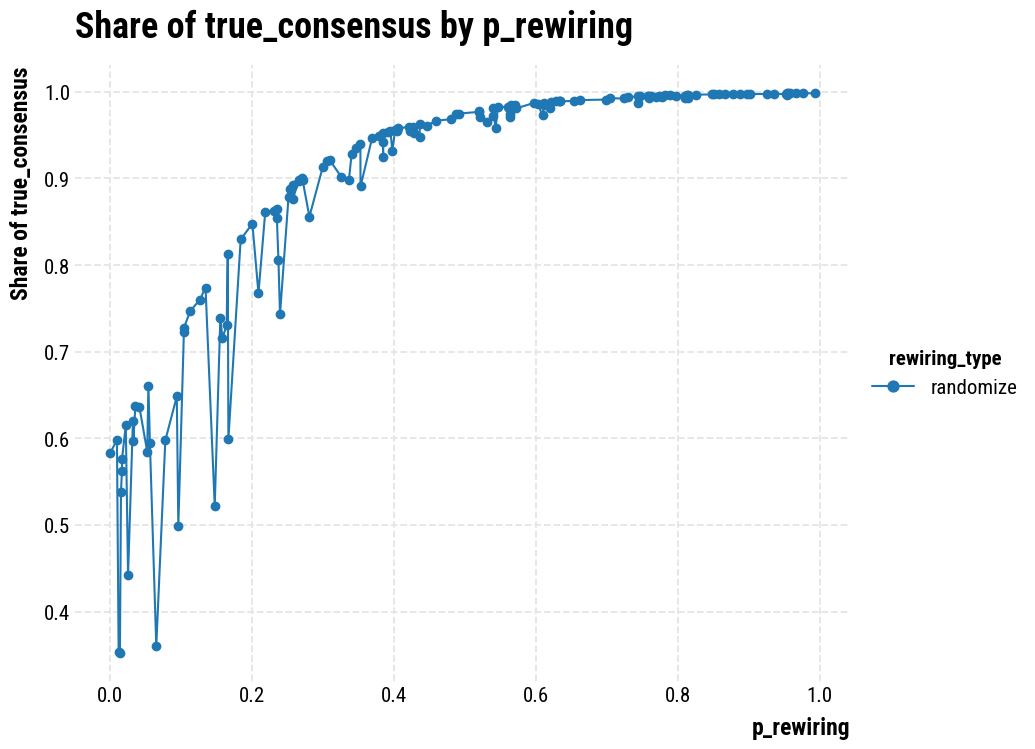

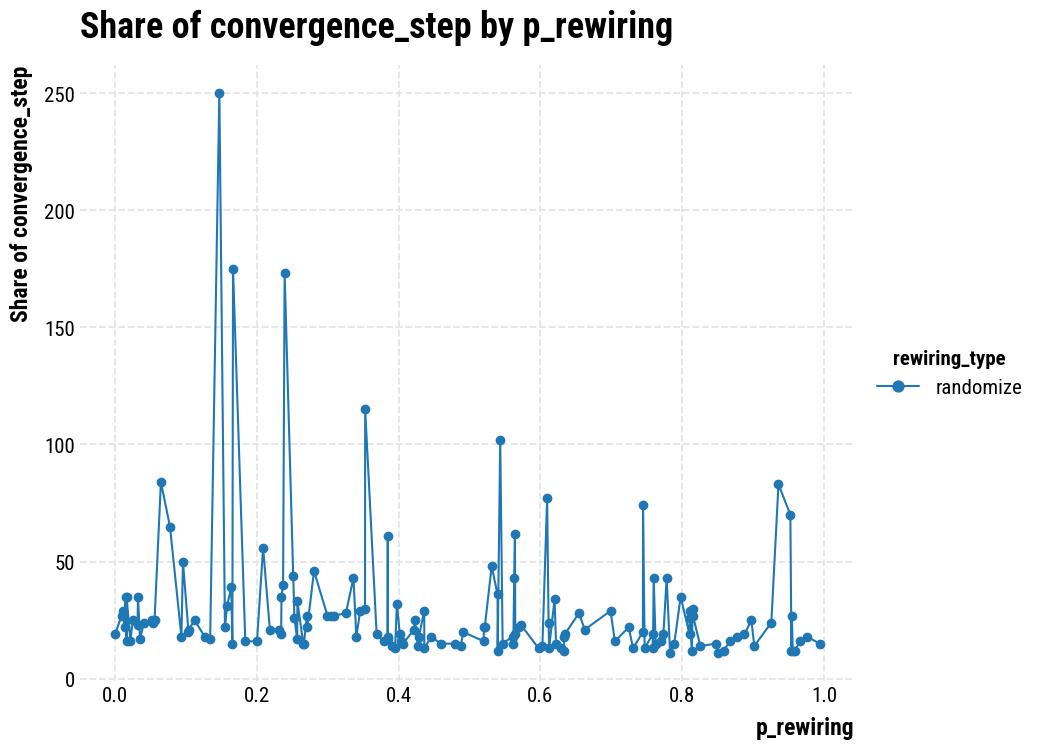

In [68]:
plot_results(bayes_results_df,variable_of_interest = 'true_consensus',regressor = 'p_rewiring')
plot_results(bayes_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring')
plot_results(beta_results_df,variable_of_interest = 'true_consensus',regressor = 'p_rewiring')
plot_results(beta_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring')

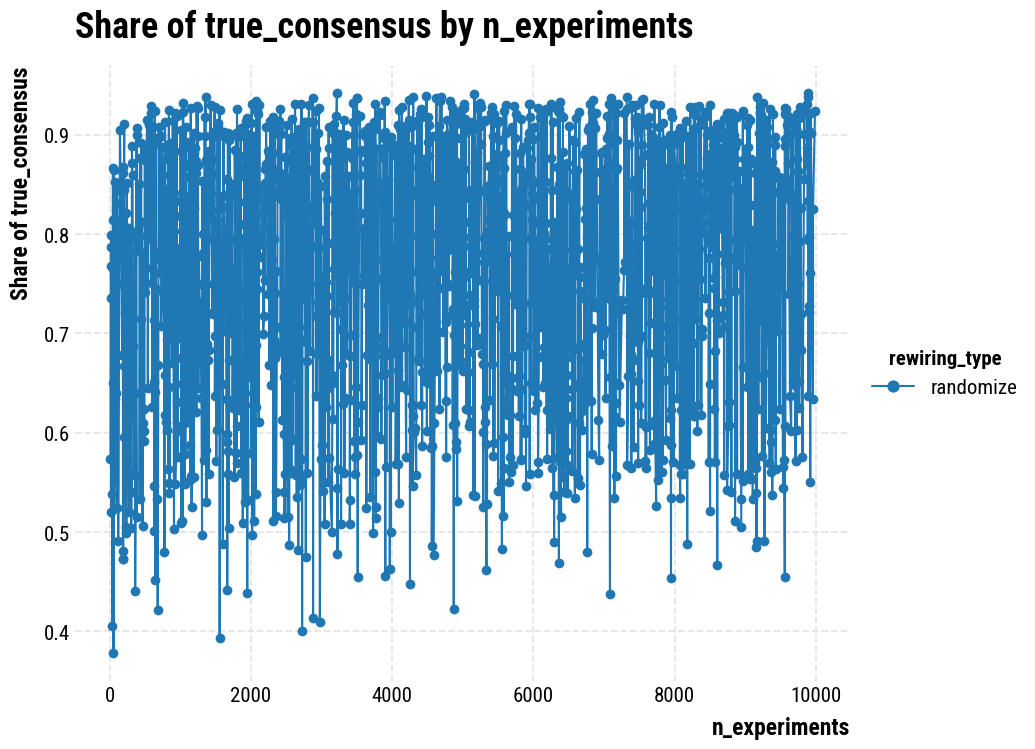

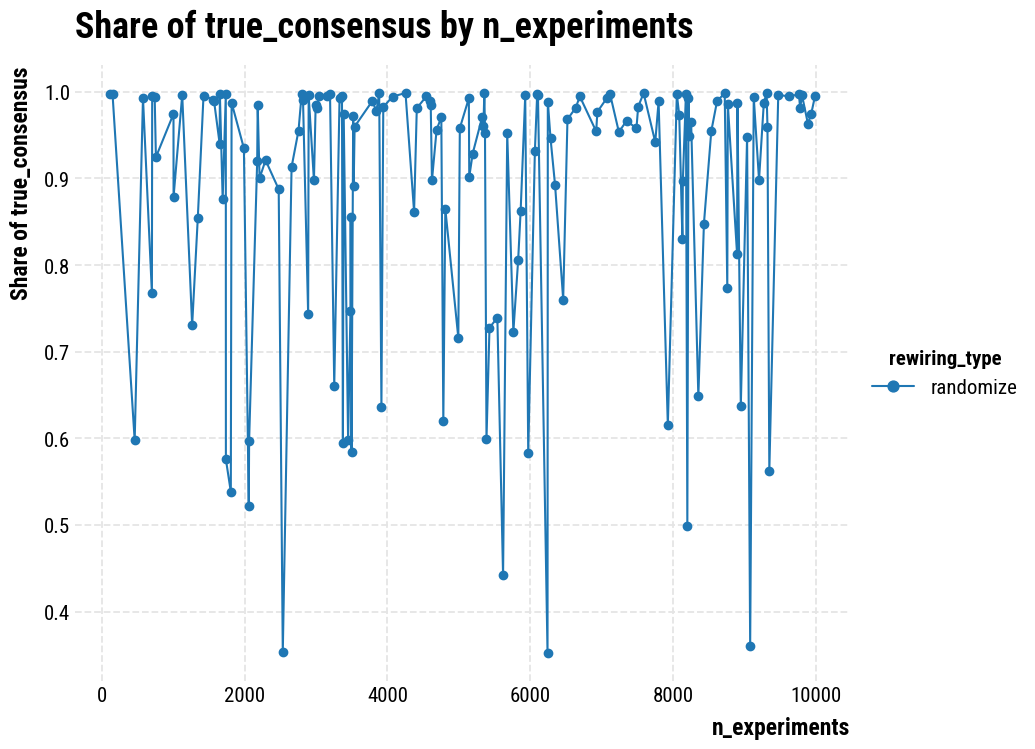

In [69]:
plot_results(bayes_results_df,variable_of_interest = 'true_consensus',regressor = 'n_experiments')
#plot_results(bayes_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring')
plot_results(beta_results_df,variable_of_interest = 'true_consensus',regressor = 'n_experiments')
#plot_results(beta_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring')

# Try Density Rewiring

## Setup

In [4]:
%%time
generate_dictionaries = False
if generate_dictionaries:
    # PERCEPTRON
    perceptron_nodes = set(G_perceptron_indexed.nodes).copy()
    perceptron_edges = set(G.edges()).copy()
    perceptron_all_edges_set = set(product(perceptron_nodes,perceptron_nodes))
    perceptron_all_new_potential_edges = perceptron_all_edges_set - perceptron_edges
    # Remove pairs where both elements are the same
    identical_pairs = {(num, num) for num in perceptron_nodes}
    perceptron_all_new_potential_edges = perceptron_all_new_potential_edges - identical_pairs
    # Save the set to a file
    with open('perceptron_all_new_potential_edges.pkl', 'wb') as file:
        pickle.dump(perceptron_all_new_potential_edges, file)

# PEPTIC ULCER
# G_pepticulcer_indexed
    pepticulcer_nodes = set(G_pepticulcer_indexed.nodes).copy()
    pepticulcer_edges = set(G_pepticulcer_indexed.edges()).copy()
    pepticulcer_all_edges_set = set(product(pepticulcer_nodes,pepticulcer_nodes))
    pepticulcer_all_new_potential_edges = pepticulcer_all_edges_set - pepticulcer_edges
    # Remove pairs where both elements are the same
    identical_pairs = {(num, num) for num in pepticulcer_nodes}
    pepticulcer_all_new_potential_edges = pepticulcer_all_new_potential_edges - identical_pairs
    # Save the set to a file
    with open('pepticulcer_all_new_potential_edges.pkl', 'wb') as file:
        pickle.dump(pepticulcer_all_new_potential_edges, file)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [5]:
def generate_parameters_empir_v2(n,G,all_new_potential_edges=set(),
                                 rewiring_type='density',valence=False):
    actual_edges = set(G.edges()).copy()
    actual_nodes = set(G.nodes).copy()
    if valence==True:
        all_new_potential_edges = all_new_potential_edges
    else:
        all_new_potential_edges = set()
    params_list = []
    #print('Generating parameters...')
    for _ in tqdm(range(n),desc="Generating parameters"):
        #n_agents = random.randint(10, 500)
        n_agents = len(G.nodes())
        #ba_degree = random.randint(1, int(n_agents/10))
        #er_prob=random.uniform(0, 0.3)
        p_rewiring = random.uniform(0, 1)
        #print(p_rewiring)
        if rewiring_type=='density':
            #G_er = nx.gnp_random_graph(n_agents, er_prob, directed=True)
            #print('densifying...')
            network = densify_network(G, p_densify=p_rewiring,valence=valence,
                                      actual_edges=actual_edges,
                                      all_new_potential_edges=all_new_potential_edges)
        # Calculate the mean degree of each node
        degrees = dict(network.degree())
        mean_degree = sum(degrees.values()) / len(degrees)
        uncertainty = random.uniform(0.001,0.025)
        n_experiments = random.randint(10, 10000)
        params = {
            "n_agents": n_agents,
            #"ba_degree": ba_degree,
            #"er_prob":er_prob,
            "p_rewiring": p_rewiring,
            'densify_valence':valence,
            "rewiring_type":rewiring_type,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments,
            'mean_degree':mean_degree
        }
        params_list.append(params)
    return params_list

In [6]:
%%time
# Load the set from a file
with open('perceptron_all_new_potential_edges.pkl', 'rb') as file:
    perceptron_all_new_potential_edges = pickle.load(file)
# Test Simulation
print('Testing parameter space')
parameter_dictionaries = generate_parameters_empir_v2(10,G_perceptron_indexed, 
                                                      all_new_potential_edges = perceptron_all_new_potential_edges,
                                                      rewiring_type='density',valence=False) # Generate parameter dictionaries
print(parameter_dictionaries)
print('testing simulation')
test_results_densify_df = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                  agent_type="bayes",tolerance=1e-02)
test_results_densify_df.to_csv('test_results_densify_df.csv', index=False)
test_results_densify_df.head()

Testing parameter space


Generating parameters: 100%|██████████| 10/10 [00:00<00:00, 32.85it/s]


[{'n_agents': 3519, 'p_rewiring': 0.21642209180453664, 'densify_valence': False, 'rewiring_type': 'density', 'network': <networkx.classes.digraph.DiGraph object at 0x7fa7e38adb40>, 'uncertainty': 0.019008543677165313, 'n_experiments': 9987, 'mean_degree': 3.4021028701335605}, {'n_agents': 3519, 'p_rewiring': 0.3481065706926263, 'densify_valence': False, 'rewiring_type': 'density', 'network': <networkx.classes.digraph.DiGraph object at 0x7fa7e38ada20>, 'uncertainty': 0.013687431828922646, 'n_experiments': 2201, 'mean_degree': 2.867860187553282}, {'n_agents': 3519, 'p_rewiring': 0.6882766585014273, 'densify_valence': False, 'rewiring_type': 'density', 'network': <networkx.classes.digraph.DiGraph object at 0x7fa7e38ad9f0>, 'uncertainty': 0.012746485744580868, 'n_experiments': 4096, 'mean_degree': 1.3742540494458653}, {'n_agents': 3519, 'p_rewiring': 0.5871527881583054, 'densify_valence': False, 'rewiring_type': 'density', 'network': <networkx.classes.digraph.DiGraph object at 0x7fa7e38ad9

Running simulations: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]

CPU times: user 7.98 s, sys: 836 ms, total: 8.81 s
Wall time: 8.98 s


,n_agents,p_rewiring,densify_valence,rewiring_type,uncertainty,n_experiments,mean_degree,true_consensus,convergence_step,agent_type
0,3519,0.216422,False,density,0.019009,9987,3.402103,0.560671,3,bayes
1,3519,0.348107,False,density,0.013687,2201,2.867860,0.506110,11,bayes
2,3519,0.688277,False,density,0.012746,4096,1.374254,0.532538,6,bayes
3,3519,0.587153,False,density,0.022874,3081,1.784030,0.539642,4,bayes
4,3519,0.421416,False,density,0.002206,4201,2.507531,0.431373,110,bayes


In [13]:
def plot_results_v2(results_df=test_results_densify_df,variable_of_interest = 'true_consensus',regressor = 'mean_degree'):
    grouped = results_df.groupby(['densify_valence', regressor])[variable_of_interest].mean().reset_index()

    # Preparing for the line plot
    #grouped['mid_bin'] = grouped['binned'].apply(lambda x: x.mid).astype(float)  # Getting the midpoint of bins for plotting

    # Plotting
    plt.figure(figsize=(10, 8))

    for rewiring_type in results_df['densify_valence'].unique():
        subset = grouped[grouped['densify_valence'] == rewiring_type]
        plt.plot(subset[regressor], subset[variable_of_interest], marker='o', label=rewiring_type)

    plt.xlabel(regressor)
    plt.ylabel('Share of '+variable_of_interest)
    plt.title('Share of '+ variable_of_interest +' by ' + regressor)
    opinionated.add_legend(title='rewiring_type')

    plt.grid(True)
    plt.show()

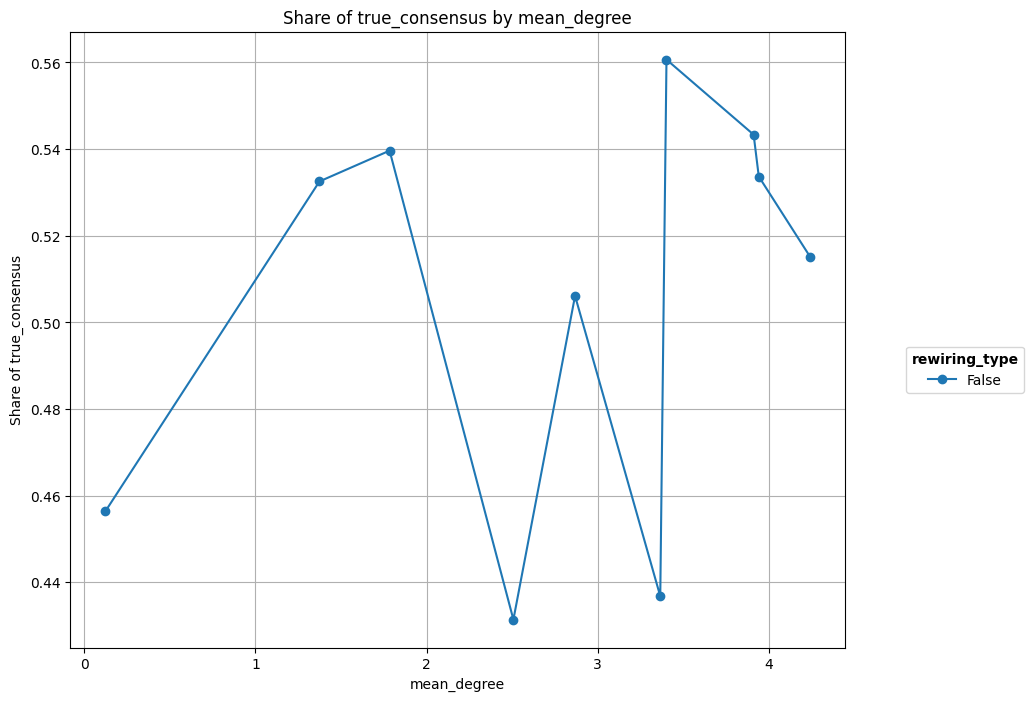

In [14]:
plot_results_v2()

## Perceptron

In [15]:
# Load the set from a file
with open('perceptron_all_new_potential_edges.pkl', 'rb') as file:
    perceptron_all_new_potential_edges = pickle.load(file)

In [16]:
%%time
print(datetime.now())
# Bayes Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 1 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_densify_df.columns)
    # First with False valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_perceptron_indexed,
                                    all_new_potential_edges = perceptron_all_new_potential_edges,                                                        
                                        rewiring_type='density',valence=False)
    results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="bayes",tolerance=1e-03)
    bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
    # Then with True valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_perceptron_indexed,
                                    all_new_potential_edges = perceptron_all_new_potential_edges,                                                        
                                        rewiring_type='density',valence=False)
    results_df2 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="bayes",tolerance=1e-03)
    bayes_results_df = pd.concat([bayes_results_df, results_df2], ignore_index=True)
    bayes_results_df.to_csv('bayesagent_perceptron_results_densify_df.csv', index=False)

saved_bayes_results_df = pd.read_csv('bayesagent_perceptron_results_densify_df.csv')

add_simulations = False
if add_simulations:
    n_sims = 250 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_densify_df.columns)
    # First with False valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_perceptron_indexed,
                                    all_new_potential_edges = perceptron_all_new_potential_edges,                                                        
                                        rewiring_type='density',valence=False)
    results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="bayes",tolerance=1e-03)
    bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
    # Then with True valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_perceptron_indexed,
                                    all_new_potential_edges = perceptron_all_new_potential_edges,                                                        
                                        rewiring_type='density',valence=True)
    results_df2 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="bayes",tolerance=1e-03)
    bayes_results_df = pd.concat([bayes_results_df, results_df2], ignore_index=True)
    bayes_results_df = pd.concat([saved_bayes_results_df, bayes_results_df], ignore_index=True)
    bayes_results_df.to_csv('bayesagent_perceptron_results_densify_df.csv', index=False)
else: 
    bayes_results_df=saved_bayes_results_df

print(datetime.now())
    
print(bayes_results_df.info())
bayes_results_df.head()

2024-07-14 17:40:04.930792
2024-07-14 17:40:04.936183
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   n_agents          500 non-null    int64  
 1   p_rewiring        500 non-null    float64
 2   densify_valence   500 non-null    bool   
 3   rewiring_type     500 non-null    object 
 4   uncertainty       500 non-null    float64
 5   n_experiments     500 non-null    int64  
 6   mean_degree       500 non-null    float64
 7   true_consensus    500 non-null    float64
 8   convergence_step  500 non-null    int64  
 9   agent_type        500 non-null    object 
dtypes: bool(1), float64(4), int64(3), object(2)
memory usage: 35.8+ KB
None
CPU times: user 9.36 ms, sys: 1.68 ms, total: 11 ms
Wall time: 12.9 ms


,n_agents,p_rewiring,densify_valence,rewiring_type,uncertainty,n_experiments,mean_degree,true_consensus,convergence_step,agent_type
0,3519,0.787602,False,density,0.006709,8759,0.903097,0.514351,10,bayes
1,3519,0.540653,False,density,0.006904,7782,2.004547,0.506962,11,bayes
2,3519,0.958661,False,density,0.010792,9668,0.181870,0.520318,5,bayes
3,3519,0.018926,False,density,0.012341,6602,4.256891,0.533959,5,bayes
4,3519,0.277772,False,density,0.022479,9348,3.145212,0.553851,3,bayes


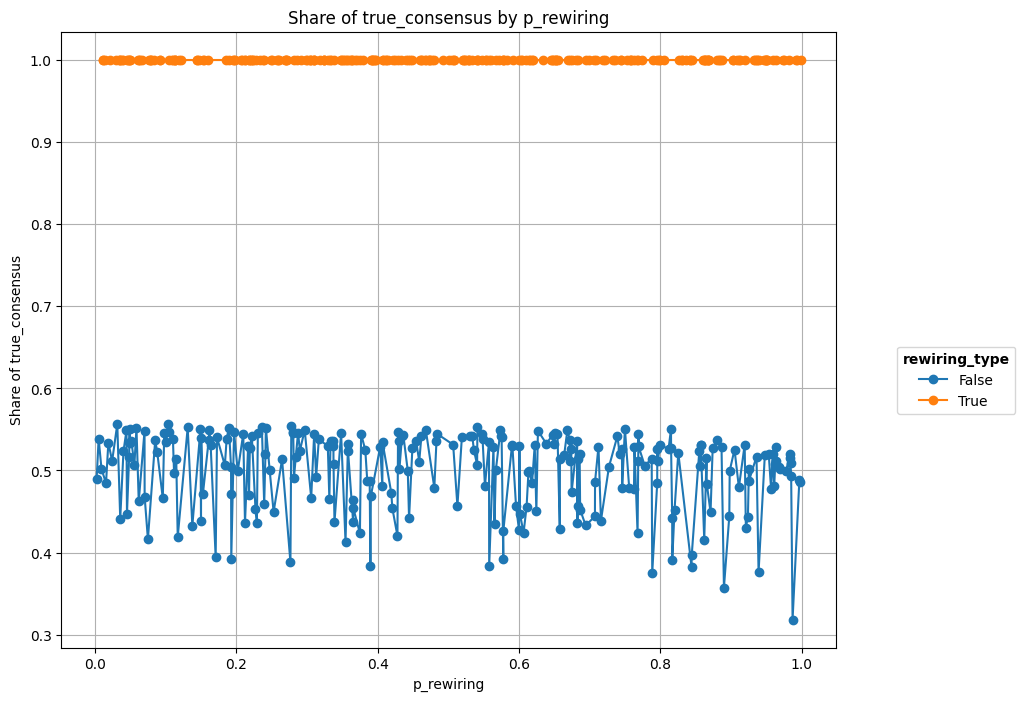

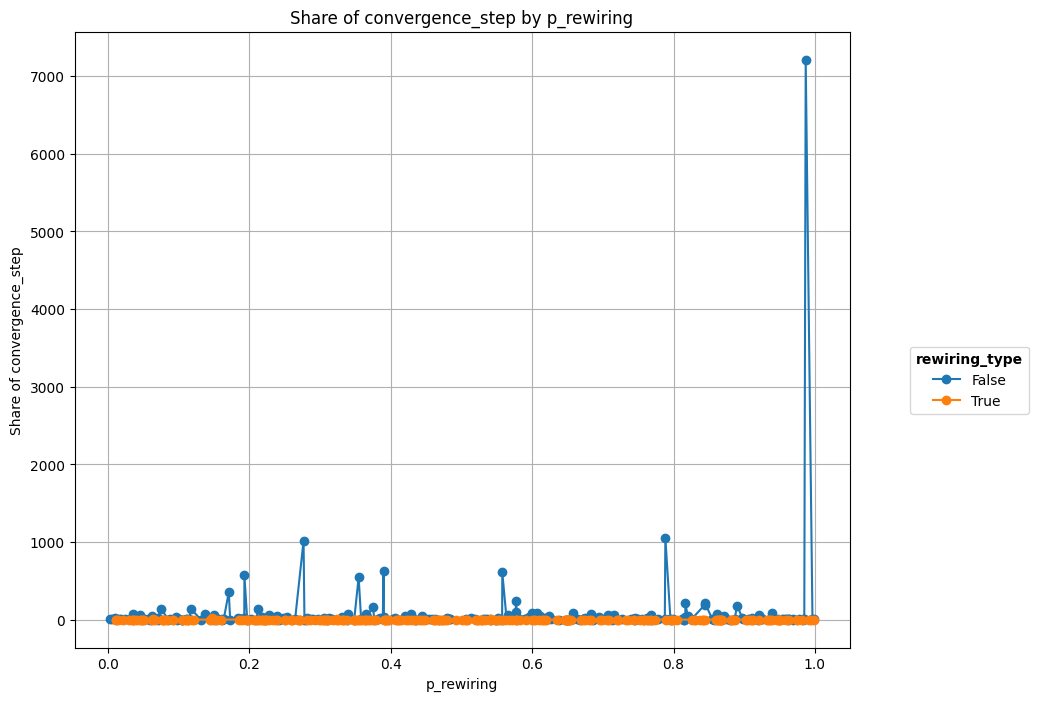

In [18]:
bayes_results_df = set()
plot_results_v2(saved_bayes_results_df,variable_of_interest = 'true_consensus',regressor = 'p_rewiring')
plot_results_v2(saved_bayes_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring')

In [46]:
%%time
print(datetime.now())
# Beta Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 1 # this is for each type of rewiring
    beta_results_df = pd.DataFrame(columns=test_results_densify_df.columns)
    # First with False valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_perceptron_indexed,
                                    all_new_potential_edges = perceptron_all_new_potential_edges,                                                        
                                        rewiring_type='density',valence=False)
    results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="beta",tolerance=1e-03)
    beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
    # Then with True valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_perceptron_indexed,
                                    all_new_potential_edges = perceptron_all_new_potential_edges,                                                        
                                        rewiring_type='density',valence=True)
    results_df2 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="beta",tolerance=1e-03)
    beta_results_df = pd.concat([beta_results_df, results_df2], ignore_index=True)
    beta_results_df.to_csv('betaagent_perceptron_results_densify_df.csv', index=False)

saved_beta_results_df = pd.read_csv('betaagent_perceptron_results_densify_df.csv')

add_simulations = False
if add_simulations:
    n_sims = 150 # this is for each type of rewiring
    beta_results_df = pd.DataFrame(columns=test_results_densify_df.columns)
    # First with False valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_perceptron_indexed,
                                    all_new_potential_edges = perceptron_all_new_potential_edges,                                                        
                                        rewiring_type='density',valence=False)
    results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="beta",tolerance=1e-03)
    beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
    # Then with True valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_perceptron_indexed,
                                    all_new_potential_edges = perceptron_all_new_potential_edges,                                                        
                                        rewiring_type='density',valence=True)
    results_df2 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="beta",tolerance=1e-03)
    beta_results_df = pd.concat([beta_results_df, results_df2], ignore_index=True)
    beta_results_df = pd.concat([saved_beta_results_df, beta_results_df], ignore_index=True)
    beta_results_df.to_csv('betaagent_perceptron_results_densify_df.csv', index=False)
else: 
    beta_results_df=saved_beta_results_df

print(datetime.now())
    
print(beta_results_df.info())
beta_results_df.head()

2024-07-14 17:16:11.684623
2024-07-14 17:16:11.690612
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   n_agents          200 non-null    int64  
 1   p_rewiring        200 non-null    float64
 2   densify_valence   200 non-null    bool   
 3   rewiring_type     200 non-null    object 
 4   uncertainty       200 non-null    float64
 5   n_experiments     200 non-null    int64  
 6   mean_degree       200 non-null    float64
 7   true_consensus    200 non-null    float64
 8   convergence_step  200 non-null    int64  
 9   agent_type        200 non-null    object 
dtypes: bool(1), float64(4), int64(3), object(2)
memory usage: 14.4+ KB
None
CPU times: user 10.2 ms, sys: 1.87 ms, total: 12 ms
Wall time: 12 ms


,n_agents,p_rewiring,densify_valence,rewiring_type,uncertainty,n_experiments,mean_degree,true_consensus,convergence_step,agent_type
0,3519,0.615541,False,density,0.019088,5452,1.666951,0.544757,15,beta
1,3519,0.943394,True,density,0.010472,895,6638.035237,1.000000,2,beta
2,3519,0.346964,False,density,0.015757,7710,2.828076,0.543052,14,beta
3,3519,0.284299,False,density,0.012245,610,3.125320,0.362887,43,beta
4,3519,0.096587,False,density,0.004292,1414,3.927252,0.258880,26,beta


In [47]:
beta_results_df = set()

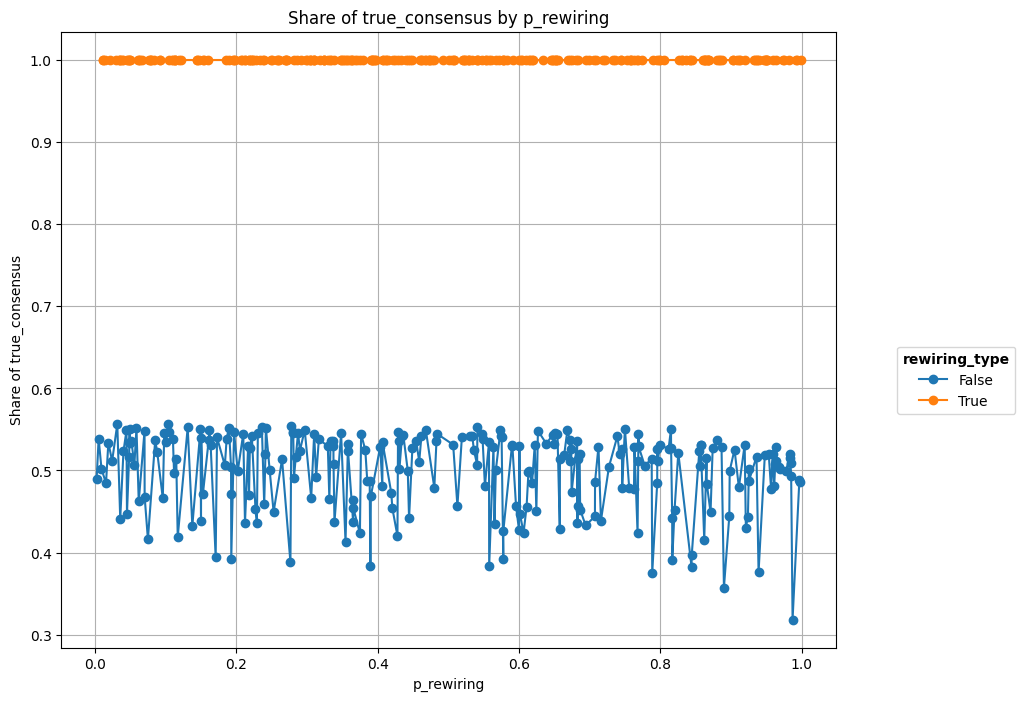

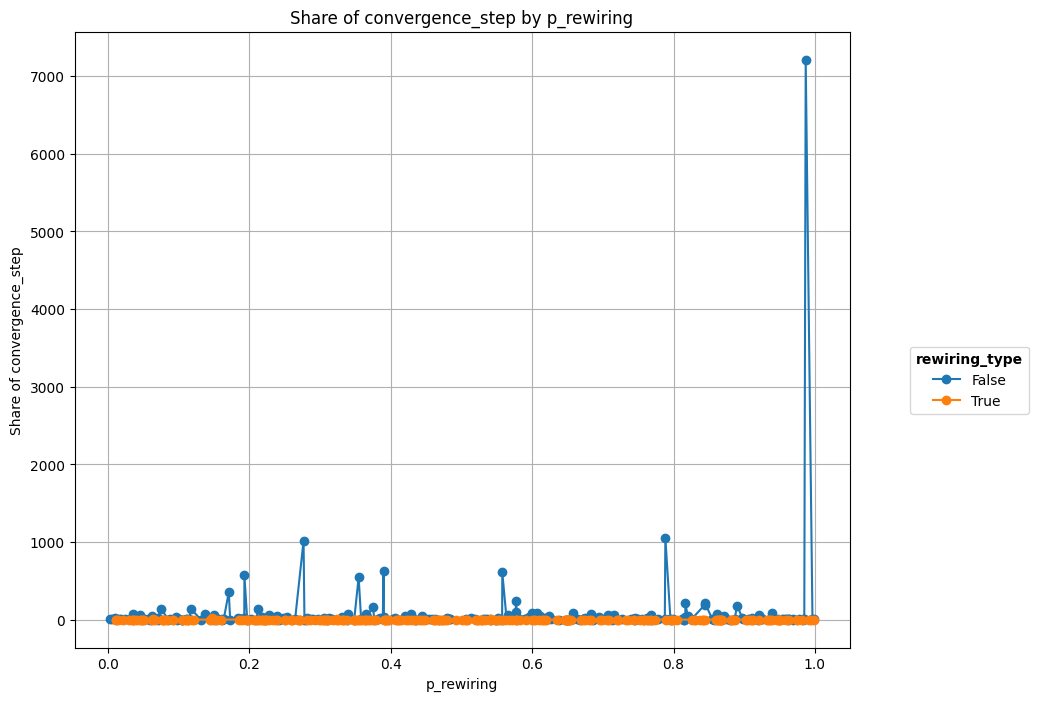

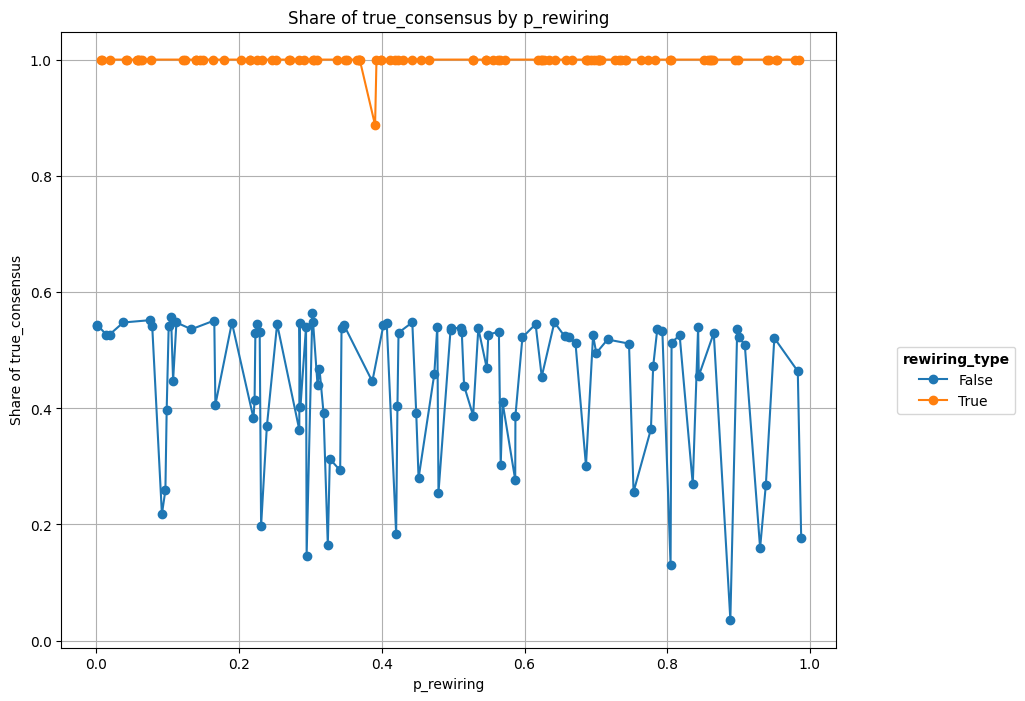

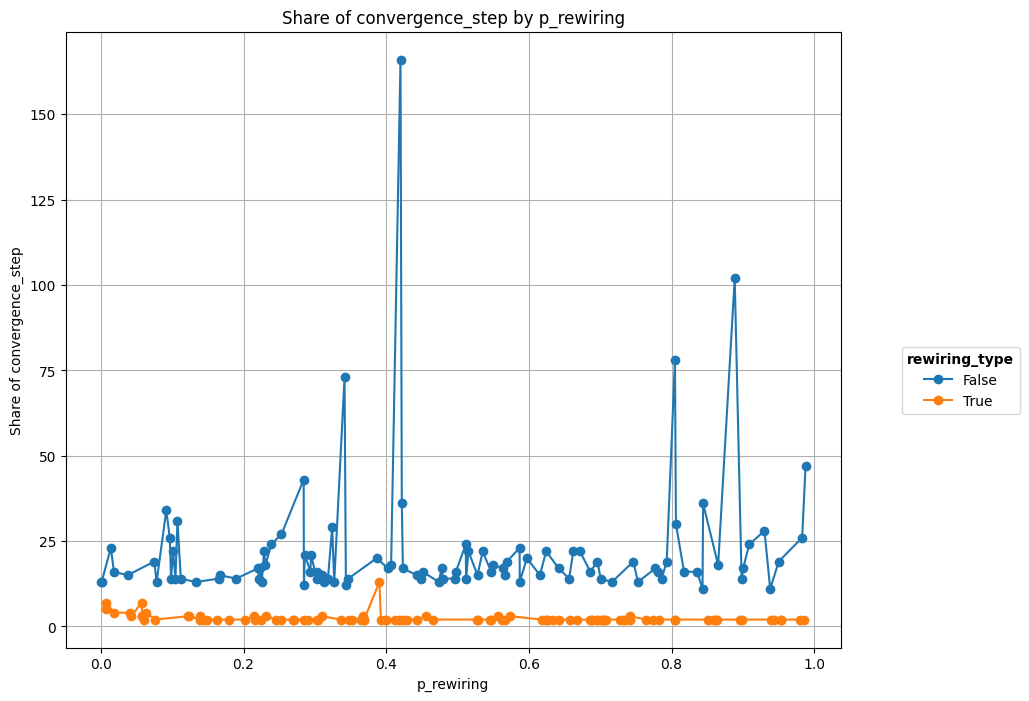

In [59]:
plot_results_v2(saved_bayes_results_df,variable_of_interest = 'true_consensus',regressor = 'p_rewiring')
plot_results_v2(saved_bayes_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring')
plot_results_v2(saved_beta_results_df,variable_of_interest = 'true_consensus',regressor = 'p_rewiring')
plot_results_v2(saved_beta_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring')

## Peptic Ulcer

In [20]:
# Load the set from a file
#with open('pepticulcer_all_new_potential_edges.pkl', 'rb') as file:
   #pepticulcer_all_new_potential_edges = pickle.load(file)
   
perceptron_all_new_potential_edges = set()
pepticulcer_all_new_potential_edges = set()

In [21]:
%%time
print(datetime.now())
# Bayes Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 1 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_densify_df.columns)
    # First with False valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_pepticulcer_indexed,
                                   # all_new_potential_edges = pepticulcer_all_new_potential_edges,
                                                    rewiring_type='density',valence=False)
    results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="bayes",tolerance=1e-03)
    bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
    # Then with True valence (SKIP FOR NOW)
   # parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_pepticulcer_indexed,
   #                                 all_new_potential_edges = pepticulcer_all_new_potential_edges,
    #                                                rewiring_type='density',valence=True)
    #results_df2 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
   #                             agent_type="bayes",tolerance=1e-03)
    #bayes_results_df = pd.concat([bayes_results_df, results_df2], ignore_index=True)
    bayes_results_df.to_csv('bayesagent_pepticulcer_results_densify_df.csv', index=False)

saved_bayes_results_df = pd.read_csv('bayesagent_pepticulcer_results_densify_df.csv')

add_simulations = False
if add_simulations:
    n_sims = 9 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_densify_df.columns)
    # First with False valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_pepticulcer_indexed,                                    all_new_potential_edges = pepticulcer_all_new_potential_edges,
                                    #all_new_potential_edges = pepticulcer_all_new_potential_edges,
                                                    rewiring_type='density',valence=False)
    results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="bayes",tolerance=1e-03)
    bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
    # Then with True valence
    #parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_pepticulcer_indexed,
    #                                all_new_potential_edges = pepticulcer_all_new_potential_edges,
     #                                           rewiring_type='density',valence=True)
    #results_df2 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
    #                            agent_type="bayes",tolerance=1e-03)
    #bayes_results_df = pd.concat([bayes_results_df, results_df2], ignore_index=True)
    bayes_results_df = pd.concat([saved_bayes_results_df, bayes_results_df], ignore_index=True)
    bayes_results_df.to_csv('bayesagent_pepticulcer_results_densify_df.csv', index=False)
else: 
    bayes_results_df=saved_bayes_results_df

print(datetime.now())
    
print(bayes_results_df.info())
bayes_results_df.head()

2024-07-14 12:57:40.507560


Running simulations: 100%|██████████| 9/9 [13:56<00:00, 92.96s/it]   

2024-07-14 13:21:05.121355
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   n_agents          10 non-null     object 
 1   p_rewiring        10 non-null     float64
 2   densify_valence   10 non-null     object 
 3   rewiring_type     10 non-null     object 
 4   uncertainty       10 non-null     float64
 5   n_experiments     10 non-null     object 
 6   mean_degree       10 non-null     float64
 7   true_consensus    10 non-null     float64
 8   convergence_step  10 non-null     object 
 9   agent_type        10 non-null     object 
dtypes: float64(4), object(6)
memory usage: 928.0+ bytes
None
CPU times: user 17min 10s, sys: 4min 29s, total: 21min 40s
Wall time: 23min 24s


,n_agents,p_rewiring,densify_valence,rewiring_type,uncertainty,n_experiments,mean_degree,true_consensus,convergence_step,agent_type
0,133403,0.342282,False,density,0.012630,3732,7.736962,0.565407,10,bayes
1,133403,0.310030,False,density,0.001410,4560,8.121856,0.449630,511,bayes
2,133403,0.921056,False,density,0.019583,7909,0.931643,0.551105,5,bayes
3,133403,0.382364,False,density,0.016675,416,7.273495,0.515536,41,bayes
4,133403,0.875056,False,density,0.005026,3561,1.467208,0.478670,47,bayes


In [22]:
bayes_results_df = set()

In [28]:
%%time
print(datetime.now())
# Beta Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 1 # this is for each type of rewiring
    beta_results_df = pd.DataFrame(columns=test_results_densify_df.columns)
    # First with False valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_pepticulcer_indexed,
                                                    rewiring_type='density',valence=False)
    results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="beta",tolerance=1e-03)
    beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
    # Then with True valence
    #parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_pepticulcer_indexed,
        #                                all_new_potential_edges = pepticulcer_all_new_potential_edges,
    #                                                rewiring_type='density',valence=True)
    #results_df2 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
     #                           agent_type="beta",tolerance=1e-03)
    #beta_results_df = pd.concat([beta_results_df, results_df2], ignore_index=True)
    beta_results_df.to_csv('betaagent_pepticulcer_results_densify_df.csv', index=False)

saved_beta_results_df = pd.read_csv('betaagent_pepticulcer_results_densify_df.csv')

add_simulations = False
if add_simulations:
    n_sims = 9 # this is for each type of rewiring
    beta_results_df = pd.DataFrame(columns=test_results_densify_df.columns)
    # First with False valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_pepticulcer_indexed,
                                                    rewiring_type='density',valence=False)
    results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="beta",tolerance=1e-03)
    beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
    # Then with True valence
    #parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_pepticulcer_indexed,
        #                                all_new_potential_edges = pepticulcer_all_new_potential_edges,
    #                                                rewiring_type='density',valence=True)
    #results_df2 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
     #                           agent_type="beta",tolerance=1e-03)
    #beta_results_df = pd.concat([beta_results_df, results_df2], ignore_index=True)
    beta_results_df = pd.concat([saved_beta_results_df, beta_results_df], ignore_index=True)
    beta_results_df.to_csv('betaagent_pepticulcer_results_densify_df.csv', index=False)
else: 
    beta_results_df=saved_beta_results_df

print(datetime.now())

print(beta_results_df.info())
beta_results_df.head()    

2024-07-14 15:57:14.742678


Running simulations: 100%|██████████| 9/9 [1:14:38<00:00, 497.56s/it]

2024-07-14 17:12:29.230495
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   n_agents          10 non-null     object 
 1   p_rewiring        10 non-null     float64
 2   densify_valence   10 non-null     object 
 3   rewiring_type     10 non-null     object 
 4   uncertainty       10 non-null     float64
 5   n_experiments     10 non-null     object 
 6   mean_degree       10 non-null     float64
 7   true_consensus    10 non-null     float64
 8   convergence_step  10 non-null     object 
 9   agent_type        10 non-null     object 
dtypes: float64(4), object(6)
memory usage: 928.0+ bytes
None
CPU times: user 1h 13min 5s, sys: 12.8 s, total: 1h 13min 17s
Wall time: 1h 15min 14s


,n_agents,p_rewiring,densify_valence,rewiring_type,uncertainty,n_experiments,mean_degree,true_consensus,convergence_step,agent_type
0,133403,0.355291,False,density,0.017003,9808,7.595796,0.578720,16,beta
1,133403,0.952522,False,density,0.012706,2132,0.563631,0.467373,32,beta
2,133403,0.434969,False,density,0.005157,8075,6.649701,0.482403,17,beta
3,133403,0.726167,False,density,0.015525,6148,3.225700,0.568398,20,beta
4,133403,0.752737,False,density,0.007585,1908,2.916651,0.406640,32,beta


In [29]:
beta_results_df = set()